In [1]:
from typing import Any
import csv
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf

2025-10-01 21:20:04.615516: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 21:20:04.653234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 21:20:05.542752: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataset_path = "/home/matv864/it/big_data/cifar/"
model_path = dataset_path + "model/cifar.keras"
train_path = dataset_path + "train/"
control_path = dataset_path + "test/"
train_labels = train_path + "trainLabels.csv"

In [3]:
# Гиперпараметры
batch_size = 64
# 10 категорий для изображений  (CIFAR-10)
num_classes = 11
# количество эпох для обучения
epochs = 20

train_size = None
test_size = None

In [4]:
labels = ['horse', 'cat', 'label', 'frog', 'airplane', 'ship', 'deer', 'bird', 'automobile', 'truck', 'dog']
labels_dict = {labels[i]: i for i in range(len(labels))}

In [5]:
def preprocess_image(image, *args):
        image = tf.image.decode_jpeg(image, channels=3) # Or decode_png, etc.
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [128, 128]) # Example resizing
        return image, *args


# START TRAINING MODEL

In [6]:

def read_labels() -> tuple[list[str], list[int]]:
    with open(train_labels, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # skip header
        image_paths = []
        labels = []
        for row in reader:
            image, word_label = row
            label = labels_dict[word_label]
            image_paths.append(f"{train_path}{image}.png")
            labels.append(label)
    return (image_paths, labels)


In [7]:
def load_data():
    global train_size, test_size

    image_paths, labels = read_labels()
    images = [tf.io.read_file(path) for path in image_paths]
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)    
    train_size = len(X_train)
    test_size = len(X_test)

    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))


    ds_train = ds_train.repeat().shuffle(1024).map(preprocess_image).batch(batch_size)
    ds_test = ds_test.repeat().shuffle(1024).map(preprocess_image).batch(batch_size)

    return ds_train, ds_test




In [8]:
def create_model(input_shape):
    # построение модели
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # сглаживание неровностей
    model.add(Flatten())
    # полносвязный слой
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    # печатаем итоговую архитектуру модели
    model.summary()
    # обучение модели с помощью оптимизатора Адама
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [9]:
# загружаем данные
ds_train, ds_test = load_data()

I0000 00:00:1759317605.976733   20276 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3179 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
# конструируем модель
model = create_model(input_shape=(128, 128, 3))
# обучаем
model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    steps_per_epoch=train_size // batch_size,
    validation_steps=test_size // batch_size,
)


/home/matv864/it/AI_work/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │        11,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,853,739 (129.14 MB)

 Trainable params: 33,853,739 (129.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-10-01 21:20:09.832937: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ee9ec003050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-01 21:20:09.832956: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-10-01 21:20:09.865795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-01 21:20:10.163312: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90501
2025-10-01 21:20:11.809520: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1548', 11260 bytes spill stores, 11408 bytes spill loads



  1/249 ━━━━━━━━━━━━━━━━━━━━ 1:34:59 23s/step - accuracy: 0.1250 - loss: 2.3913

I0000 00:00:1759317631.371111   20343 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.1763 - loss: 2.2674

2025-10-01 21:21:04.100027: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads



249/249 ━━━━━━━━━━━━━━━━━━━━ 63s 161ms/step - accuracy: 0.2396 - loss: 2.0699 - val_accuracy: 0.3430 - val_loss: 1.9007
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.3716 - loss: 1.7505 - val_accuracy: 0.4178 - val_loss: 1.6270
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.4531 - loss: 1.5046 - val_accuracy: 0.4950 - val_loss: 1.4029
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.5142 - loss: 1.3445 - val_accuracy: 0.5214 - val_loss: 1.3234
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.5680 - loss: 1.1983 - val_accuracy: 0.5486 - val_loss: 1.2773
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.6213 - loss: 1.0574 - val_accuracy: 0.5731 - val_loss: 1.2352
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.6678 - loss: 0.9274 - val_accuracy: 0.5701 - val_loss: 1.2766
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.7223 - loss: 0.7846 - val

In [11]:
# сохраняем модель на диске
model.save(str(model_path))

# LAUNCHING READY MODEL

In [12]:
model = load_model(str(model_path))

In [13]:
def load_control_data() -> tuple[Any, int]:
    image_paths = [f"{control_path}{str(i)}" for i in os.listdir(control_path)]
    images = [tf.io.read_file(path) for path in image_paths]

    ds = tf.data.Dataset.from_tensor_slices((images, image_paths))

    ds = ds.repeat().shuffle(1024).map(preprocess_image).batch(batch_size)

    return ds, len(images)


2025-10-01 21:31:57.666438: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 60 bytes spill stores, 60 bytes spill loads



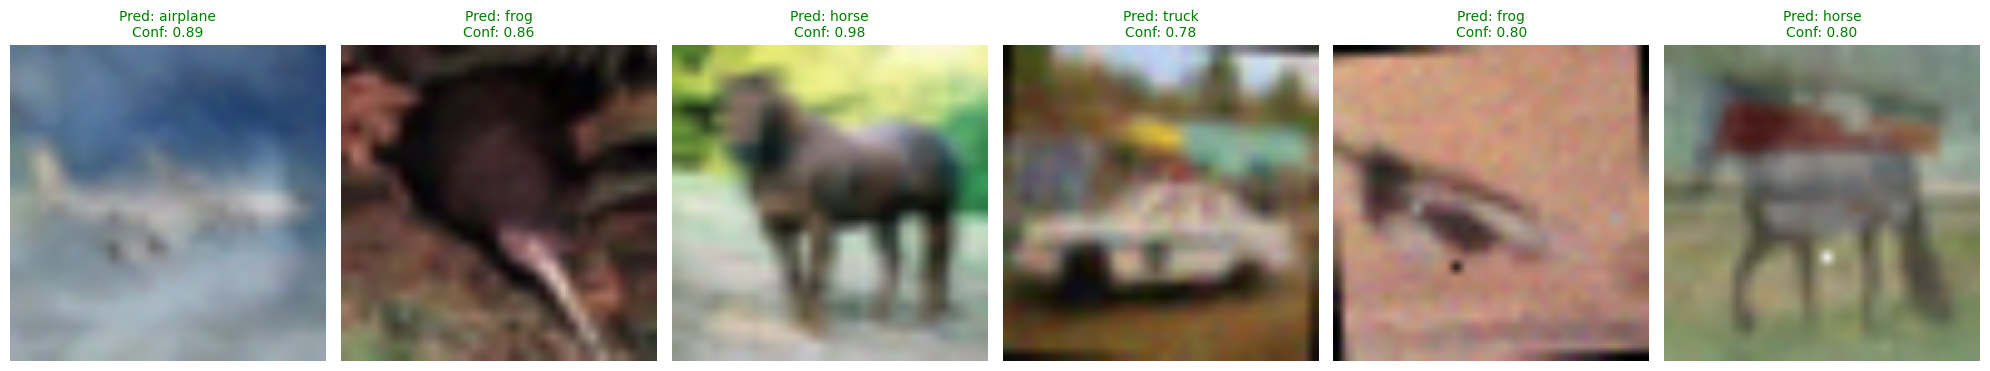

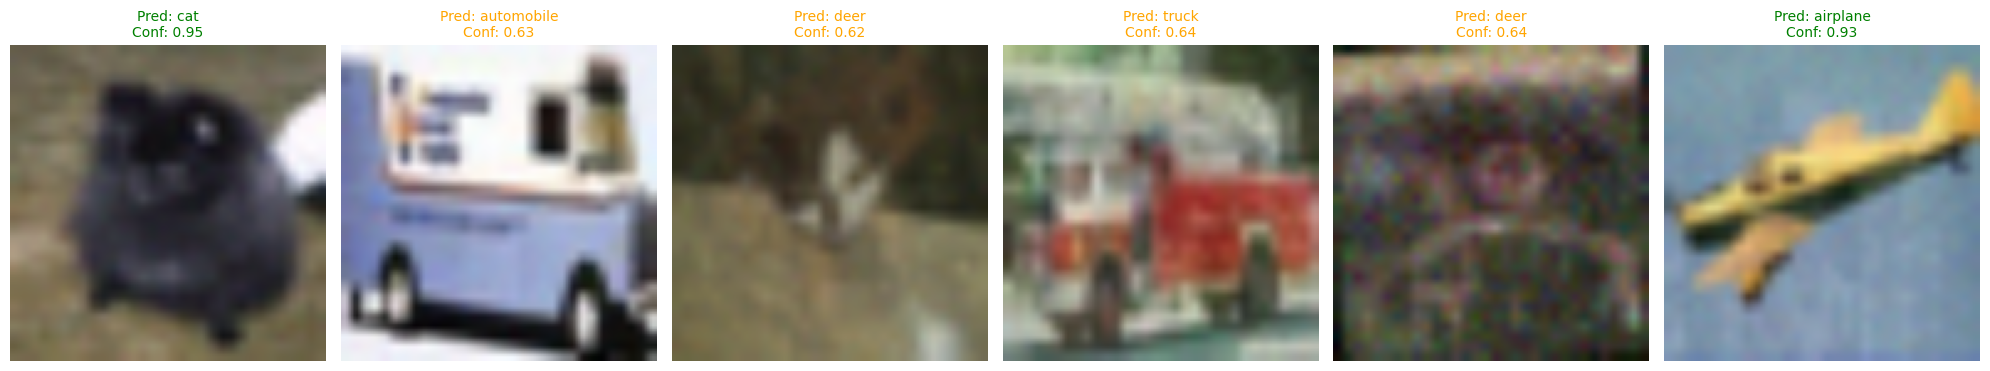

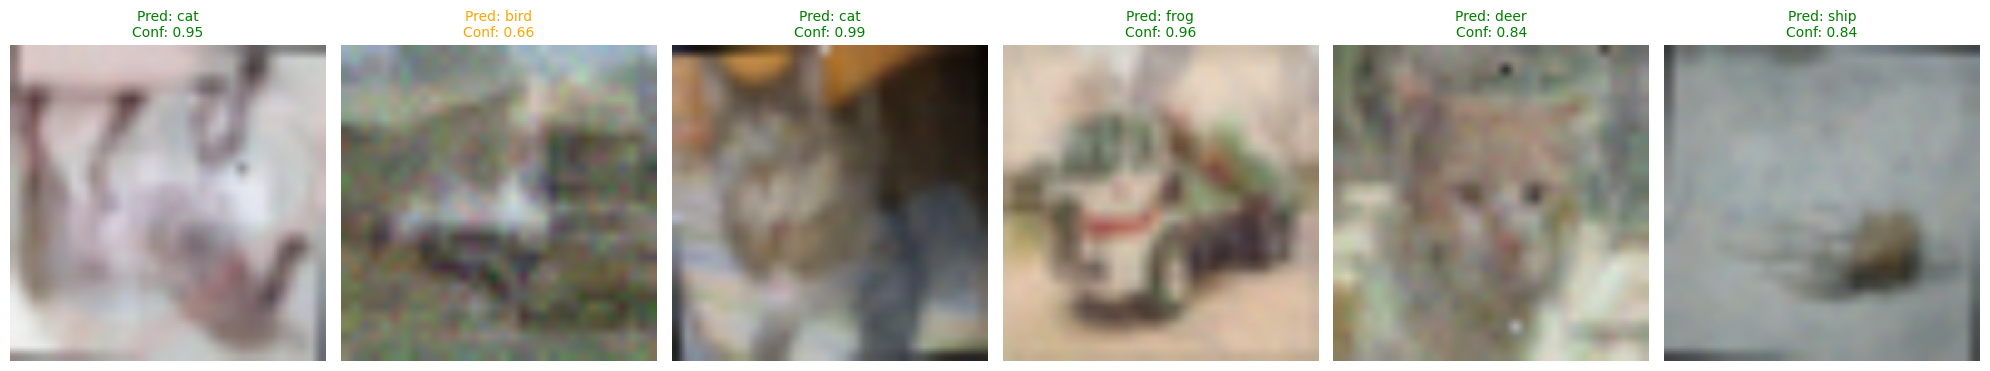

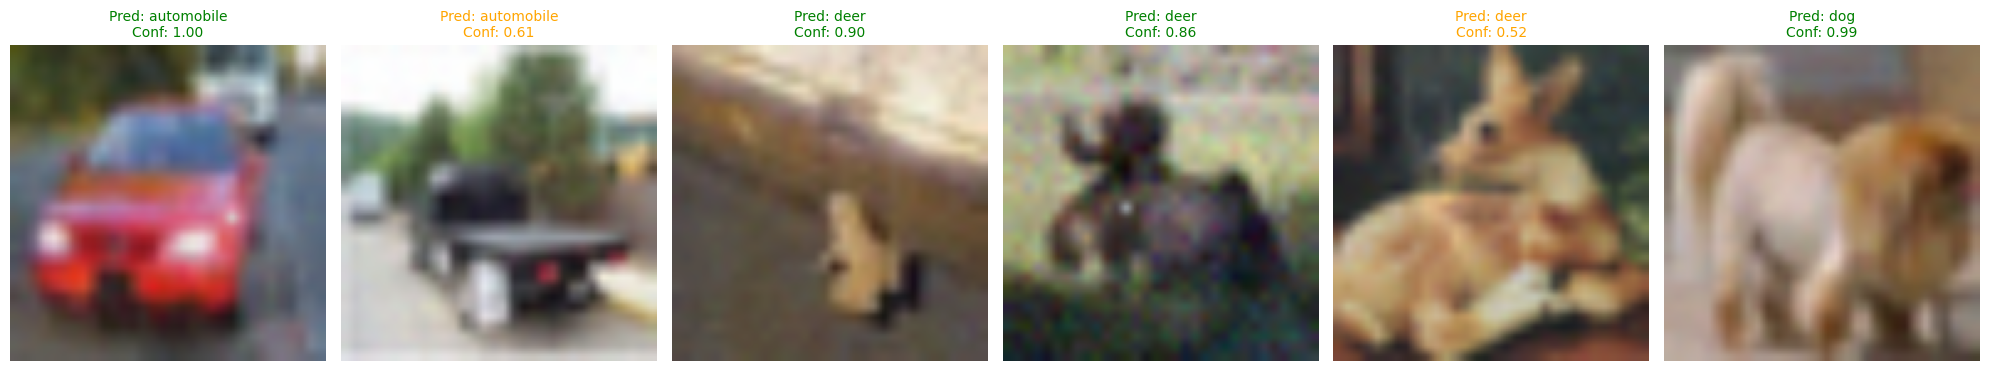

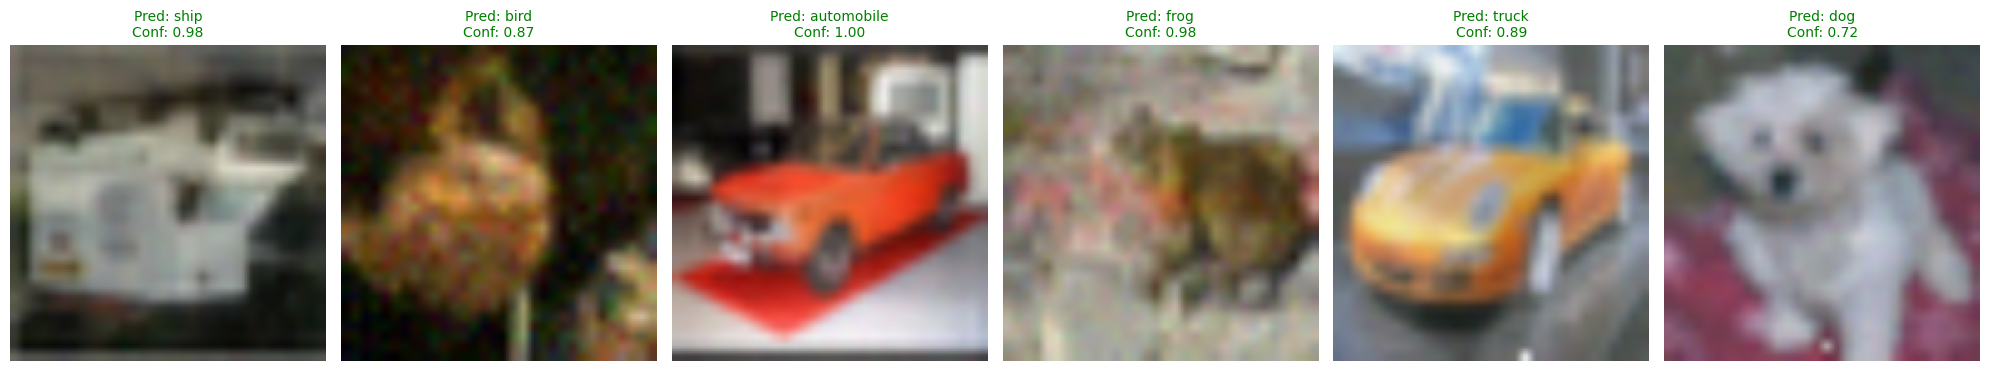

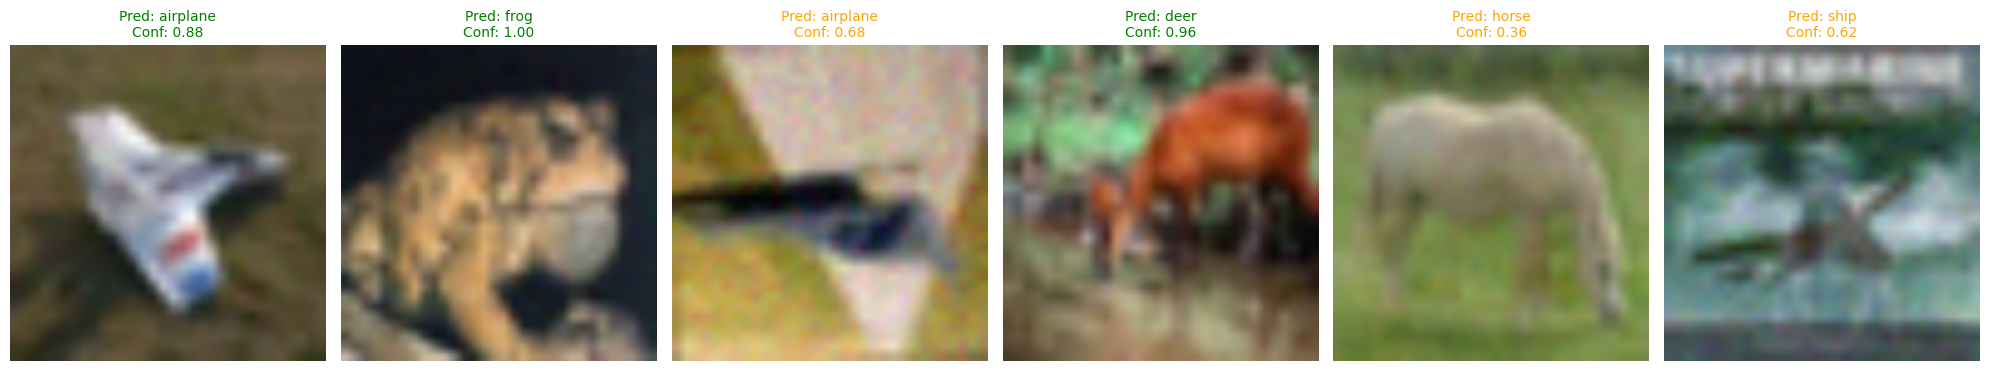

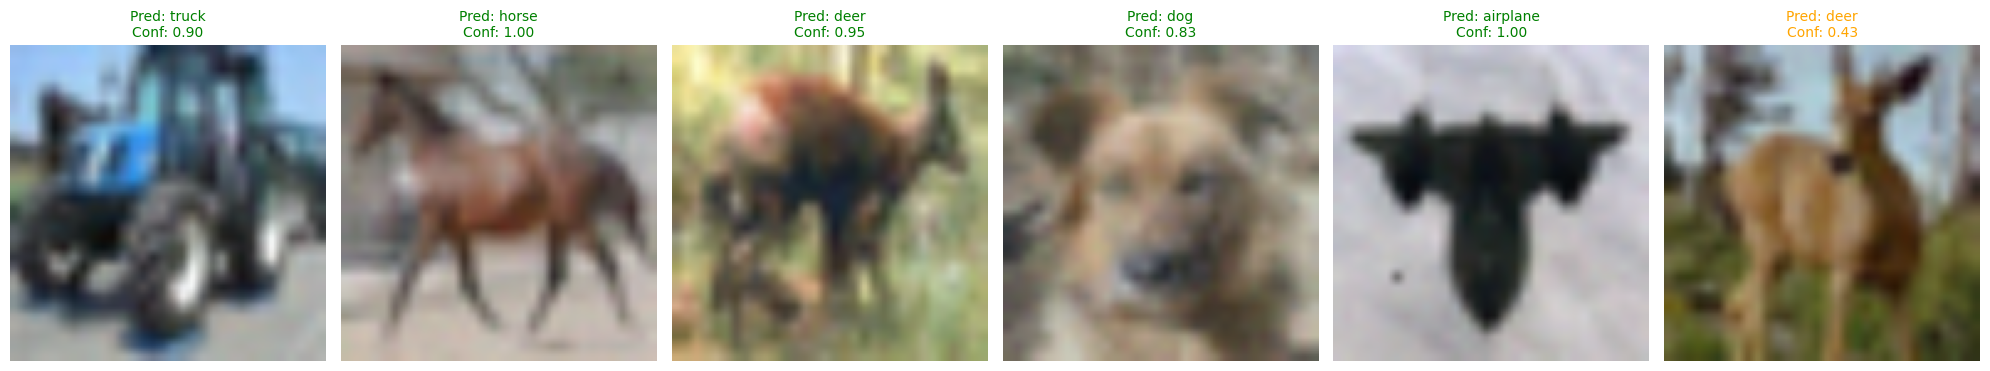

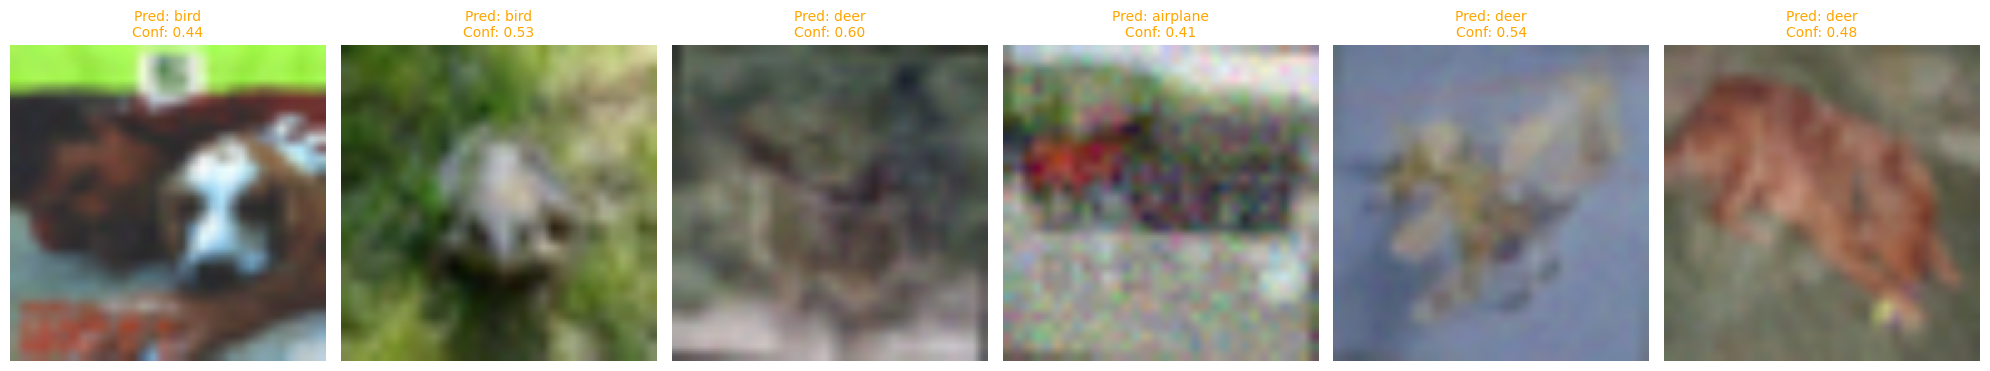

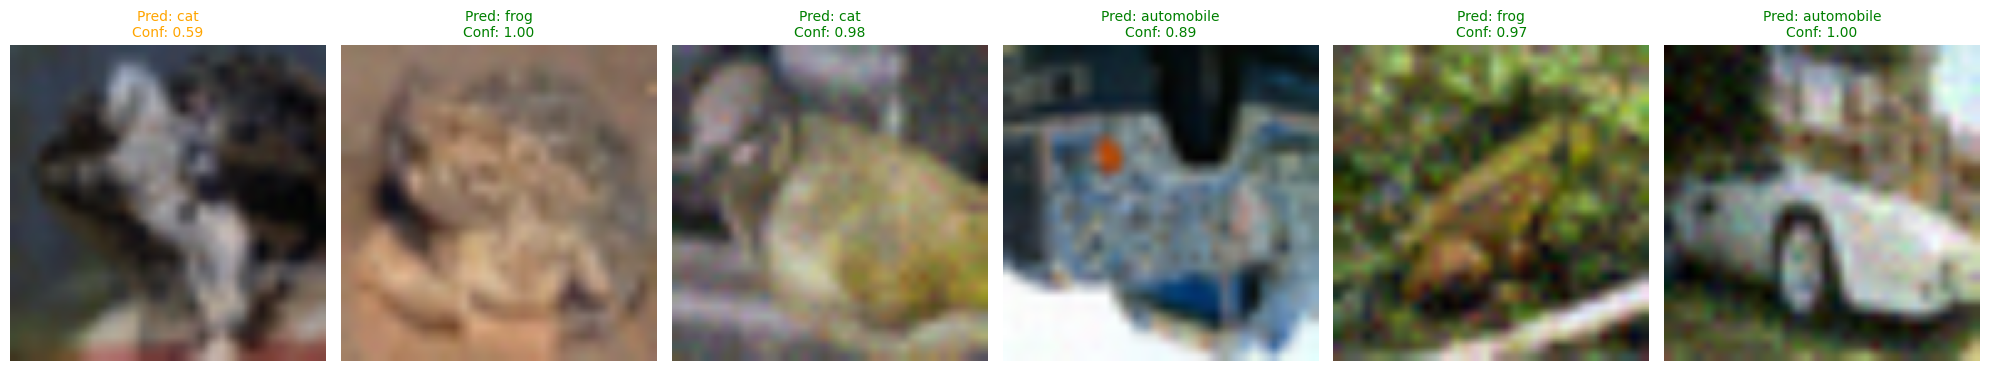

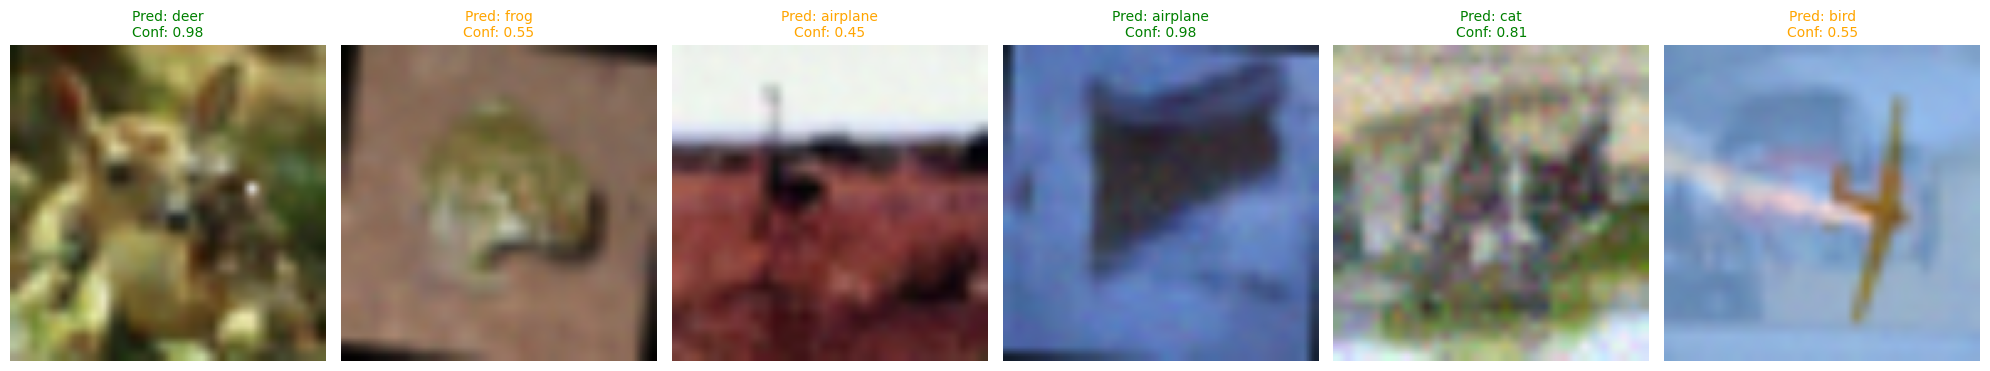

2025-10-01 21:32:04.952049: W tensorflow/core/framework/op_kernel.cc:1855] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 64 of dimension 0 out of bounds.
2025-10-01 21:32:04.952068: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: slice index 64 of dimension 0 out of bounds.
2025-10-01 21:32:04.976019: W tensorflow/core/framework/op_kernel.cc:1855] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 66 of dimension 0 out of bounds.
2025-10-01 21:32:04.976038: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: slice index 66 of dimension 0 out of bounds.
2025-10-01 21:32:05.025446: W tensorflow/core/framework/op_kernel.cc:1855] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 72 of dimension 0 out of bounds.
2025-10-01 21:32:05.059207: W tensorflow/core/framework/op_kernel.cc:1

KeyboardInterrupt: 

In [ ]:
ds, ds_size = load_control_data()

for images, paths in ds.take(1):
    predictions = model.predict(images, verbose=0)

    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)

    size_of_set = 6
    for set_i in range(ds_size // size_of_set):
        fig, axes = plt.subplots(1, size_of_set, figsize=(20, 4))
        for i in range(6):
            img_num = set_i * size_of_set + i

            try:
                img = images[img_num].numpy()
                # if img.min() < 0 or img.max() > 1:  # Если нормализовано
                #     img = (img - img.min()) / (img.max() - img.min())
            except Exception:
                break

            # Показываем изображение
            axes[i].imshow(img)
            axes[i].axis('off')
            
            # Добавляем предсказание
            pred_class = predicted_classes[img_num]
            confidence = confidence_scores[img_num]
            predicted_label = labels[pred_class]
            
            axes[i].set_title(
                f"Pred: {predicted_label}\nConf: {confidence:.2f}",
                fontsize=10, color='green' if confidence > 0.7 else 'orange'
            )
        else:
            plt.tight_layout()
            plt.show()
            plt.close()

    break  # Только один батч